In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

In [2]:
input_dir = 'output-files-bootstrap-test6b-4d-1a'


with open( '%s/train-and-true-samples.npy' % input_dir, 'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)
    
print('\n\n')
print(' shape of train_pts:  %s' % str(train_pts.shape))
print(' shape of true_pts:   %s' % str(true_pts.shape))
print('\n\n')






 shape of train_pts:  (4000000, 4)
 shape of true_pts:   (400000, 4)





In [3]:
config_file = '%s/config.txt' % (input_dir)

if not exists(config_file) :
    
    print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
    sys.exit()
    

In [4]:
ndim = int(cu.get_par( config_file, "ndim"))
print("\n\n Number of feature dimensions: %d\n\n" % ndim)



 Number of feature dimensions: 4




In [5]:
with open( '%s/config-pars.npy' % input_dir, 'rb') as f :
    train_mu = np.load(f, allow_pickle=True )
    train_rho = np.load(f, allow_pickle=True)
    train_sig = np.load(f, allow_pickle=True)    
    true_mu = np.load(f, allow_pickle=True )
    true_rho = np.load(f, allow_pickle=True)
    true_sig = np.load(f, allow_pickle=True)  
    resolution = np.load(f, allow_pickle=True)

<function matplotlib.pyplot.show(close=None, block=None)>

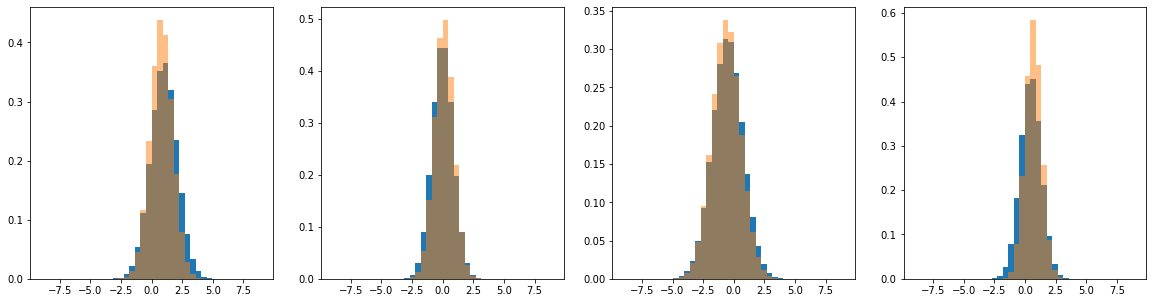

In [6]:
fig,ax = plt.subplots( 1, 4, figsize=(20,5))



hmin=-5
hmax=5


hmin=-9
hmax=9

hbins=40


for i in range(ndim) :
        ax[i].hist( train_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

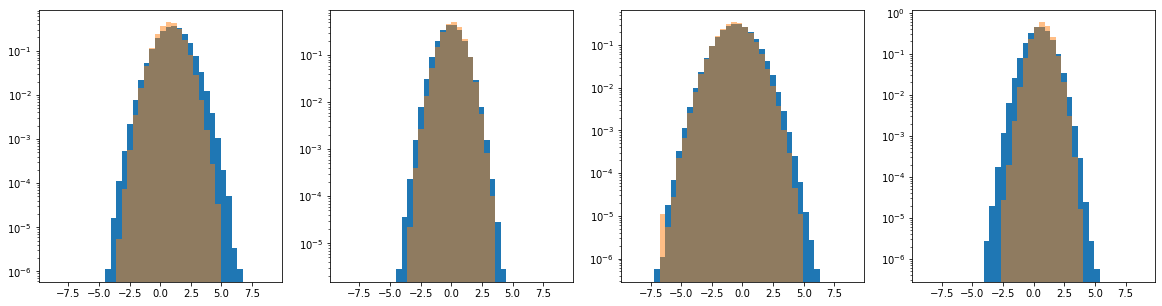

In [7]:
fig,ax = plt.subplots( 1, 4, figsize=(20,5))

hbins=40


for i in range(ndim) :
        ax[i].hist( train_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
        ax[i].set_yscale('log')
    
plt.show

In [8]:
with open( "%s/omnifold-output-weights.npy" % input_dir,'rb') as f :
    main_sample_omnifold_weights = np.load(f)


<function matplotlib.pyplot.show(close=None, block=None)>

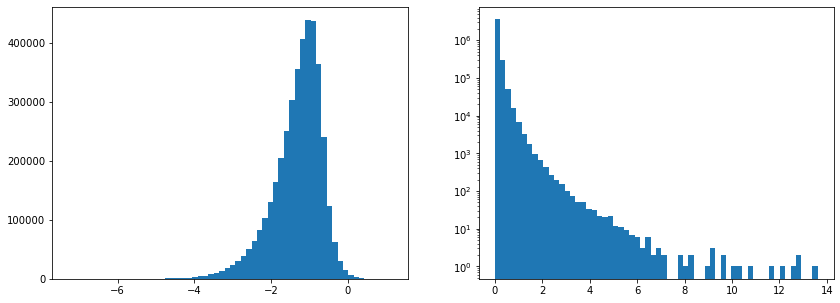

In [9]:
fig,ax = plt.subplots( 1, 2, figsize=(2*7,5))

hbins = 60
ax[0].hist( np.log10(main_sample_omnifold_weights), bins=hbins)
ax[1].hist( main_sample_omnifold_weights, bins=hbins)
ax[1].set_yscale('log')
plt.show

In [10]:
true_rho

array([list([0.4, -0.3, 0.0]), list([0.0, 0.2]), list([0.5])],
      dtype=object)

In [11]:
true_mu.shape

(4,)

In [12]:
true_cov = np.zeros( shape=(ndim,ndim) )

for i in range(ndim) :
    for j in range(ndim) :
        k = ndim - j - 1
        if i == j :
            true_cov[i][j] = true_sig[i]*true_sig[i]
        elif j > i :
            print(" %d, %d, %d" % (i,j,k))
            true_cov[i][j] = true_rho[i][k] * true_sig[i] * true_sig[j]

 0, 1, 2
 0, 2, 1
 0, 3, 0
 1, 2, 1
 1, 3, 0
 2, 3, 0


In [13]:
true_cov

array([[ 0.64 ,  0.   , -0.24 ,  0.192],
       [ 0.   ,  0.36 ,  0.12 ,  0.   ],
       [ 0.   ,  0.   ,  1.   ,  0.3  ],
       [ 0.   ,  0.   ,  0.   ,  0.36 ]])

In [14]:
have_fits = False

if exists( "%s/fit-results.npy" % input_dir ) :
    have_fits = True
    print("\n\n Have fit results file.\n\n")



 Have fit results file.




In [15]:
if have_fits :
    
    with open( '%s/fit-results.npy' % input_dir, 'rb' ) as f :
        fit_results_mean_val = np.load(f, allow_pickle=True )
        fit_results_mean_err = np.load(f, allow_pickle=True )
        fit_results_cov_val = np.load(f, allow_pickle=True )
        fit_results_cov_err = np.load(f, allow_pickle=True )        
        

    ave_fit_err_mean = np.zeros( ndim )

    for fi in range(ndim) :
    
        ave_fit_err_mean[fi] = np.mean( fit_results_mean_err[fi,:])
    

In [16]:
def calc_mean( weights, fi ) :
    
    mean = ( np.sum( weights * train_pts[:,fi]) ) / ( np.sum( weights ) )
    
    return mean

In [17]:
def calc_rms( weights, fi ) :
    
    x = calc_mean( weights, fi )
    xx = ( np.sum( weights * train_pts[:,fi] * train_pts[:,fi] ) ) / ( np.sum( weights ) )
    
    #print(" x = %f,  xx = %f" % (x, xx))
    
    return np.sqrt(xx - x*x)


In [18]:
def calc_cov( weights, fi1, fi2 ) :
    
    x1 = calc_mean( weights, fi1 )
    x2 = calc_mean( weights, fi2 )
    x1x2 = ( np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] ) ) / ( np.sum( weights ) )
    
    return np.sqrt( x1x2 - x1*x2 )
    

In [19]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * train_pts[:,fi1] )
    wx2 = np.sum( weights * train_pts[:,fi2] )
    wx1x2 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi1] )
        wx2x2 = np.sum( weights * train_pts[:,fi2] * train_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [20]:
n_samples = 0

for fi in range(1000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d bootstrap samples.\n\n" % n_samples )



 Found 50 bootstrap samples.




In [21]:
%%time

all_mean = np.zeros( shape=(ndim,n_samples) )
all_rms = np.zeros( shape=(ndim,n_samples) )
all_cov = np.zeros( shape=(ndim,ndim,n_samples) )
all_rho = np.zeros( shape=(ndim,ndim,n_samples) )


si = 0

for fi in range(200) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        
        print('\n----- %s exists' % fname )
        
        with open(fname,'rb') as f :
            
            final_push_weights_scaled = np.load(f)
            print( len(final_push_weights_scaled))
            print( final_push_weights_scaled )
            print( true_pts[:,0])
            
            for fi1 in range(ndim) :
                for fi2 in range(fi1,ndim) :
                    mean_cov = calc_mean_cov( final_push_weights_scaled, fi1, fi2 )
                    all_cov[fi1,fi2,si] = mean_cov["cov_x1x2"]
                    all_cov[fi2,fi1,si] = mean_cov["cov_x1x2"]
                    if ( fi1 == fi2 ) :
                        print( "  %d %d  :  mean = %8.4f, RMS = %8.4f, cov = %8.4f" % 
                              (fi1, fi2, mean_cov["mean_x1"], mean_cov["rms1"], mean_cov["cov_x1x2"]))
                        all_mean[fi1,si] = mean_cov["mean_x1"]
                        all_rms[fi1,si] = mean_cov["rms1"]
                    else :
                        print( "  %d %d  :  rho = %8.4f,  cov = %8.4f" %
                              (fi1, fi2, mean_cov["rho12"], mean_cov["cov_x1x2"]) )
                        all_rho[fi1,fi2,si] = mean_cov["rho12"]
                        all_rho[fi2,fi1,si] = mean_cov["rho12"]
                        
        si = si + 1
        
            


----- output-files-bootstrap-test6b-4d-1a/bootstrap-weights-000.npy exists
4000000
[0.02070318 0.02826934 0.06413373 ... 0.03830937 0.07524047 0.03379093]
[ 0.6176891   0.61758615 -0.72189844 ...  0.39585613  0.1060989
  1.00935076]
  0 0  :  mean =   0.7974, RMS =   0.8006, cov =   0.6409
  0 1  :  rho =  -0.0031,  cov =  -0.0015
  0 2  :  rho =  -0.2999,  cov =  -0.2405
  0 3  :  rho =   0.3933,  cov =   0.1890
  1 1  :  mean =   0.1004, RMS =   0.6061, cov =   0.3673
  1 2  :  rho =   0.2045,  cov =   0.1242
  1 3  :  rho =   0.0036,  cov =   0.0013
  2 2  :  mean =  -0.5981, RMS =   1.0019, cov =   1.0037
  2 3  :  rho =   0.5005,  cov =   0.3010
  3 3  :  mean =   0.6982, RMS =   0.6002, cov =   0.3602

----- output-files-bootstrap-test6b-4d-1a/bootstrap-weights-001.npy exists
4000000
[0.020529   0.02635229 0.06627814 ... 0.04066649 0.07971533 0.03102656]
[ 0.6176891   0.61758615 -0.72189844 ...  0.39585613  0.1060989
  1.00935076]
  0 0  :  mean =   0.8016, RMS =   0.8016, cov =

  0 3  :  rho =   0.3978,  cov =   0.1930
  1 1  :  mean =   0.0978, RMS =   0.6034, cov =   0.3640
  1 2  :  rho =   0.1995,  cov =   0.1207
  1 3  :  rho =   0.0072,  cov =   0.0026
  2 2  :  mean =  -0.6004, RMS =   1.0031, cov =   1.0062
  2 3  :  rho =   0.4993,  cov =   0.3018
  3 3  :  mean =   0.7002, RMS =   0.6027, cov =   0.3632

----- output-files-bootstrap-test6b-4d-1a/bootstrap-weights-012.npy exists
4000000
[0.01798952 0.02817121 0.06338759 ... 0.03500437 0.09721212 0.03330248]
[ 0.6176891   0.61758615 -0.72189844 ...  0.39585613  0.1060989
  1.00935076]
  0 0  :  mean =   0.8007, RMS =   0.8027, cov =   0.6444
  0 1  :  rho =  -0.0043,  cov =  -0.0021
  0 2  :  rho =  -0.2966,  cov =  -0.2385
  0 3  :  rho =   0.3982,  cov =   0.1916
  1 1  :  mean =   0.1031, RMS =   0.6022, cov =   0.3626
  1 2  :  rho =   0.2030,  cov =   0.1225
  1 3  :  rho =   0.0048,  cov =   0.0017
  2 2  :  mean =  -0.5975, RMS =   1.0017, cov =   1.0034
  2 3  :  rho =   0.4983,  cov =   0.299

  0 3  :  rho =   0.3963,  cov =   0.1907
  1 1  :  mean =   0.1034, RMS =   0.6037, cov =   0.3644
  1 2  :  rho =   0.1997,  cov =   0.1211
  1 3  :  rho =  -0.0005,  cov =  -0.0002
  2 2  :  mean =  -0.5970, RMS =   1.0050, cov =   1.0099
  2 3  :  rho =   0.4979,  cov =   0.3000
  3 3  :  mean =   0.6975, RMS =   0.5996, cov =   0.3595

----- output-files-bootstrap-test6b-4d-1a/bootstrap-weights-024.npy exists
4000000
[0.0216301  0.02609871 0.06541698 ... 0.03408188 0.09194567 0.03240699]
[ 0.6176891   0.61758615 -0.72189844 ...  0.39585613  0.1060989
  1.00935076]
  0 0  :  mean =   0.8020, RMS =   0.8034, cov =   0.6454
  0 1  :  rho =  -0.0031,  cov =  -0.0015
  0 2  :  rho =  -0.2997,  cov =  -0.2413
  0 3  :  rho =   0.3997,  cov =   0.1925
  1 1  :  mean =   0.1001, RMS =   0.6028, cov =   0.3634
  1 2  :  rho =   0.1999,  cov =   0.1208
  1 3  :  rho =   0.0015,  cov =   0.0005
  2 2  :  mean =  -0.6049, RMS =   1.0023, cov =   1.0045
  2 3  :  rho =   0.4959,  cov =   0.297

  0 3  :  rho =   0.3979,  cov =   0.1924
  1 1  :  mean =   0.1006, RMS =   0.6020, cov =   0.3624
  1 2  :  rho =   0.1975,  cov =   0.1189
  1 3  :  rho =   0.0032,  cov =   0.0012
  2 2  :  mean =  -0.5961, RMS =   1.0005, cov =   1.0010
  2 3  :  rho =   0.4992,  cov =   0.3002
  3 3  :  mean =   0.6998, RMS =   0.6010, cov =   0.3612

----- output-files-bootstrap-test6b-4d-1a/bootstrap-weights-036.npy exists
4000000
[0.01934269 0.0276802  0.06044491 ... 0.03982877 0.08754407 0.03845167]
[ 0.6176891   0.61758615 -0.72189844 ...  0.39585613  0.1060989
  1.00935076]
  0 0  :  mean =   0.8003, RMS =   0.8010, cov =   0.6415
  0 1  :  rho =  -0.0005,  cov =  -0.0003
  0 2  :  rho =  -0.2978,  cov =  -0.2390
  0 3  :  rho =   0.3923,  cov =   0.1887
  1 1  :  mean =   0.1036, RMS =   0.6016, cov =   0.3619
  1 2  :  rho =   0.1972,  cov =   0.1189
  1 3  :  rho =   0.0031,  cov =   0.0011
  2 2  :  mean =  -0.5972, RMS =   1.0020, cov =   1.0041
  2 3  :  rho =   0.5027,  cov =   0.302

  0 3  :  rho =   0.3979,  cov =   0.1924
  1 1  :  mean =   0.1023, RMS =   0.6004, cov =   0.3605
  1 2  :  rho =   0.1991,  cov =   0.1194
  1 3  :  rho =   0.0023,  cov =   0.0008
  2 2  :  mean =  -0.5987, RMS =   0.9989, cov =   0.9979
  2 3  :  rho =   0.4986,  cov =   0.2988
  3 3  :  mean =   0.7011, RMS =   0.5999, cov =   0.3599

----- output-files-bootstrap-test6b-4d-1a/bootstrap-weights-048.npy exists
4000000
[0.01796733 0.02686152 0.06610249 ... 0.03642186 0.09099682 0.03448119]
[ 0.6176891   0.61758615 -0.72189844 ...  0.39585613  0.1060989
  1.00935076]
  0 0  :  mean =   0.8015, RMS =   0.8014, cov =   0.6423
  0 1  :  rho =  -0.0050,  cov =  -0.0024
  0 2  :  rho =  -0.2923,  cov =  -0.2338
  0 3  :  rho =   0.3990,  cov =   0.1925
  1 1  :  mean =   0.1001, RMS =   0.6037, cov =   0.3645
  1 2  :  rho =   0.2020,  cov =   0.1217
  1 3  :  rho =   0.0035,  cov =   0.0013
  2 2  :  mean =  -0.5994, RMS =   0.9982, cov =   0.9964
  2 3  :  rho =   0.5025,  cov =   0.302

<function matplotlib.pyplot.show(close=None, block=None)>

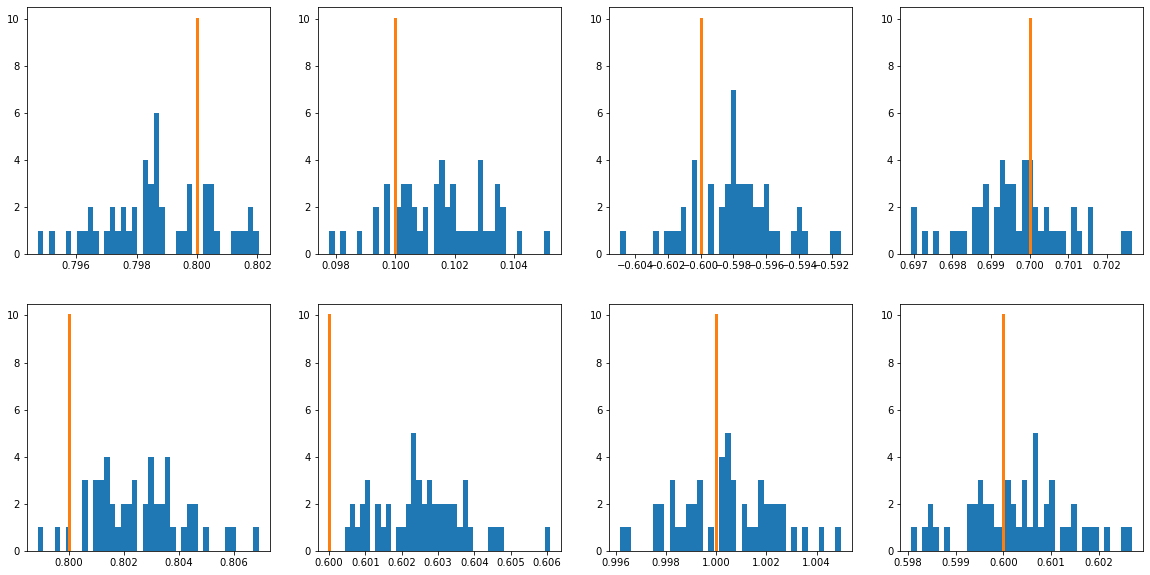

In [22]:
fig,ax = plt.subplots( 2, 4, figsize=(20,10))

ymax = 10

for i in range(ndim) :
    
    ax[0][i].hist( all_mean[i], bins=40)
    ax[1][i].hist( all_rms[i], bins=40)
    
    ax[0][i].plot( (true_mu[i], true_mu[i]), (0,ymax), linewidth=3 )
    ax[1][i].plot( (true_sig[i], true_sig[i]), (0,ymax), linewidth=3 )

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

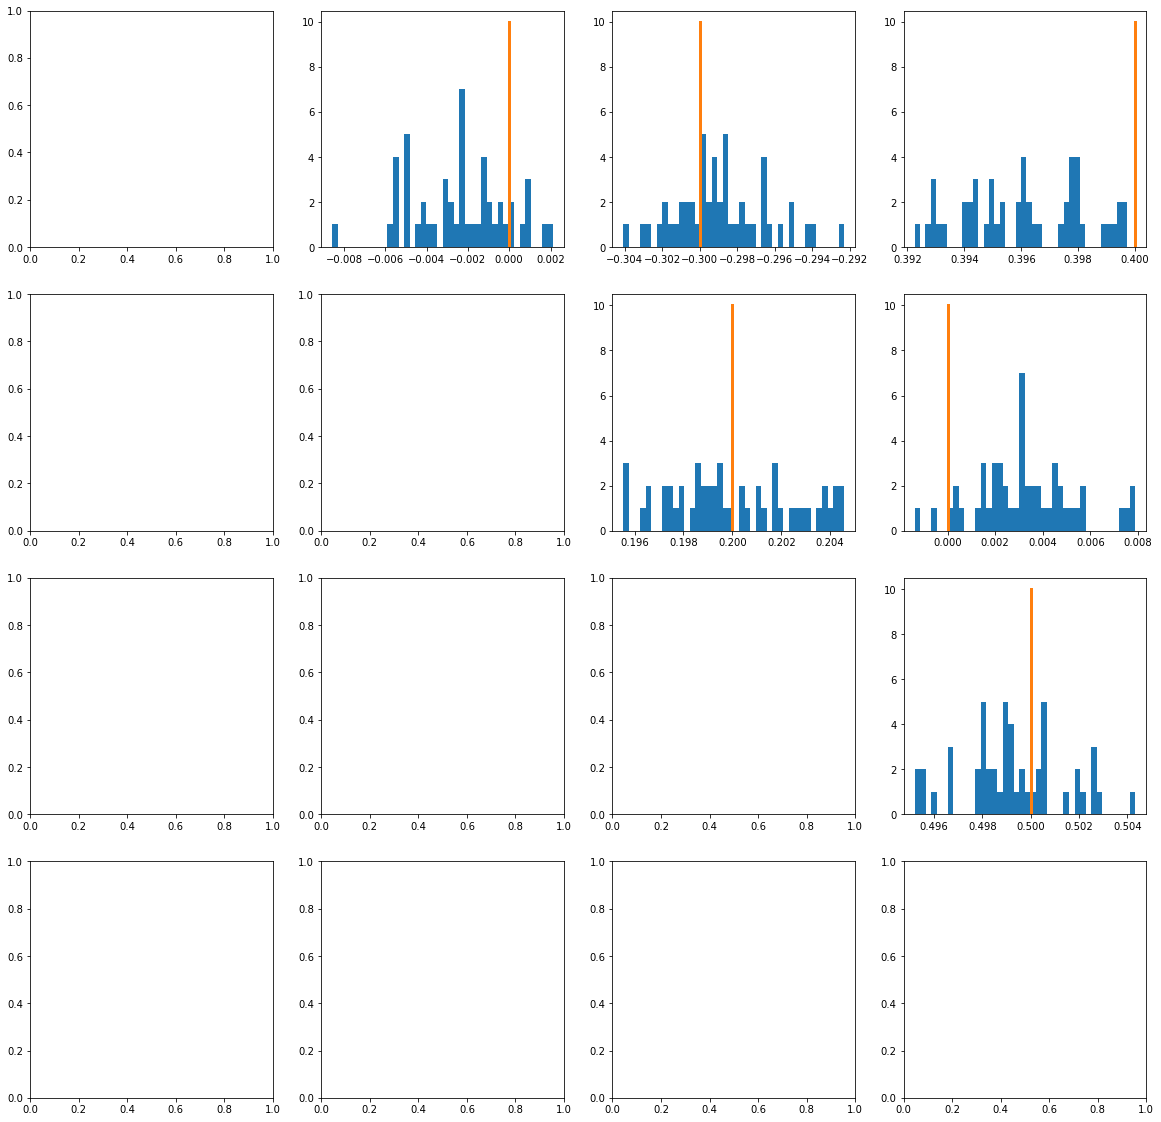

In [23]:
fig,ax = plt.subplots( 4, 4, figsize=(20,20))

ymax = 10

for i in range(0,ndim-1) :
    
    for j in range(i+1,ndim) :
        
        k = ndim - j - 1
        
        ax[i][j].hist( all_rho[i,j], bins=40)
        
        ax[i][j].plot( (true_rho[i][k], true_rho[i][k]), (0, ymax), linewidth=3 )
    


plt.show

In [24]:
print('\n')

ave_mean = np.zeros( ndim )
rms_mean = np.zeros( ndim )

ave_cov = np.zeros( shape=(ndim,ndim) )
rms_cov = np.zeros( shape=(ndim,ndim) )


for fi in range(ndim) :
    
    ave_mean[fi] = np.mean( all_mean[fi] )
    ave_mean2 = np.mean( all_mean[fi]*all_mean[fi])
    rms_mean[fi] = np.sqrt( ave_mean2 - ave_mean[fi]*ave_mean[fi] )
    print("  feature %d  :  mean   ave %8.4f  (true %8.4f), rms %8.4f" % (fi, ave_mean[fi], true_mu[fi], rms_mean[fi] ))
    
print('\n')

for fi in range(ndim) :
    
    ave_rms = np.mean( all_rms[fi] )
    ave_rms2 = np.mean( all_rms[fi]*all_rms[fi])
    rms_rms = np.sqrt( ave_rms2 - ave_rms*ave_rms )
    print("  feature %d  :  RMS    ave %8.4f  (true %8.4f), rms %8.4f" % (fi, ave_rms, true_sig[fi], rms_rms ))
    
print('\n')

for fi1 in range(0,ndim-1) :
    for fi2 in range(fi1+1, ndim) :
        k = ndim - fi2 - 1
        ave_rho = np.mean( all_rho[fi1,fi2])
        ave_rho2 = np.mean( all_rho[fi1,fi2]*all_rho[fi1,fi2] )
        rms_rho = np.sqrt( ave_rho2 - ave_rho*ave_rho )
        print("  feature %d, %d  :  rho    ave %8.4f  (true %8.4f), rms %8.4f" % ( fi1, fi2, ave_rho, true_rho[fi1][k], rms_rho ))
        
print("\n")

for fi1 in range(0,ndim) :
    for fi2 in range(fi1,ndim) :
        ave_cov[fi1,fi2] = np.mean( all_cov[fi1][fi2] )
        ave_cov2 = np.mean( all_cov[fi1][fi2]*all_cov[fi1][fi2] )
        rms_cov[fi1,fi2] = np.sqrt( ave_cov2 - ave_cov[fi1,fi2]*ave_cov[fi1,fi2] )
        print("  feature %d, %d  :  cov    ave %8.4f  (true %8.4f), rms %8.4f" %
              (fi1, fi2, ave_cov[fi1,fi2], true_cov[fi1,fi2], rms_cov[fi1,fi2] ) )

print("\n")



  feature 0  :  mean   ave   0.7987  (true   0.8000), rms   0.0018
  feature 1  :  mean   ave   0.1015  (true   0.1000), rms   0.0016
  feature 2  :  mean   ave  -0.5979  (true  -0.6000), rms   0.0026
  feature 3  :  mean   ave   0.6996  (true   0.7000), rms   0.0012


  feature 0  :  RMS    ave   0.8026  (true   0.8000), rms   0.0017
  feature 1  :  RMS    ave   0.6025  (true   0.6000), rms   0.0012
  feature 2  :  RMS    ave   1.0004  (true   1.0000), rms   0.0019
  feature 3  :  RMS    ave   0.6003  (true   0.6000), rms   0.0011


  feature 0, 1  :  rho    ave  -0.0024  (true   0.0000), rms   0.0023
  feature 0, 2  :  rho    ave  -0.2989  (true  -0.3000), rms   0.0024
  feature 0, 3  :  rho    ave   0.3961  (true   0.4000), rms   0.0021
  feature 1, 2  :  rho    ave   0.2000  (true   0.2000), rms   0.0026
  feature 1, 3  :  rho    ave   0.0032  (true   0.0000), rms   0.0020
  feature 2, 3  :  rho    ave   0.4992  (true   0.5000), rms   0.0021


  feature 0, 0  :  cov    ave   0.64

## Save the simple direct calculation results for setting fit parameter ranges from RMS.

In [25]:
with open( '%s/simple-calc-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, ave_mean )
    np.save( f, rms_mean )
    np.save( f, ave_cov )
    np.save( f, rms_cov )

In [26]:
if have_fits :
    
    for si in range( n_samples ) :
        
        for fi in range( 1,2 ) :
            print("  sample %3d :  mean%d   calc  %8.4f  fit %8.4f" % 
                  (si, fi, all_mean[fi,si], fit_results_mean_val[fi,si]))

  sample   0 :  mean1   calc    0.1004  fit   0.1004
  sample   1 :  mean1   calc    0.1033  fit   0.1034
  sample   2 :  mean1   calc    0.1018  fit   0.1018
  sample   3 :  mean1   calc    0.1013  fit   0.1013
  sample   4 :  mean1   calc    0.1004  fit   0.1004
  sample   5 :  mean1   calc    0.1027  fit   0.1027
  sample   6 :  mean1   calc    0.0982  fit   0.0982
  sample   7 :  mean1   calc    0.1003  fit   0.1003
  sample   8 :  mean1   calc    0.1016  fit   0.1016
  sample   9 :  mean1   calc    0.1034  fit   0.1034
  sample  10 :  mean1   calc    0.1003  fit   0.1003
  sample  11 :  mean1   calc    0.0978  fit   0.0978
  sample  12 :  mean1   calc    0.1031  fit   0.1031
  sample  13 :  mean1   calc    0.0993  fit   0.0993
  sample  14 :  mean1   calc    0.1015  fit   0.1015
  sample  15 :  mean1   calc    0.1035  fit   0.1035
  sample  16 :  mean1   calc    0.1002  fit   0.1002
  sample  17 :  mean1   calc    0.1008  fit   0.1008
  sample  18 :  mean1   calc    0.1032  fit   

   0 : x axis limits:  0.794, 0.802    y axis limits  0.794, 0.802
   1 : x axis limits:  0.097, 0.106    y axis limits  0.097, 0.106
   2 : x axis limits:  -0.606, -0.591    y axis limits  -0.606, -0.591
   3 : x axis limits:  0.697, 0.703    y axis limits  0.697, 0.703


<function matplotlib.pyplot.show(close=None, block=None)>

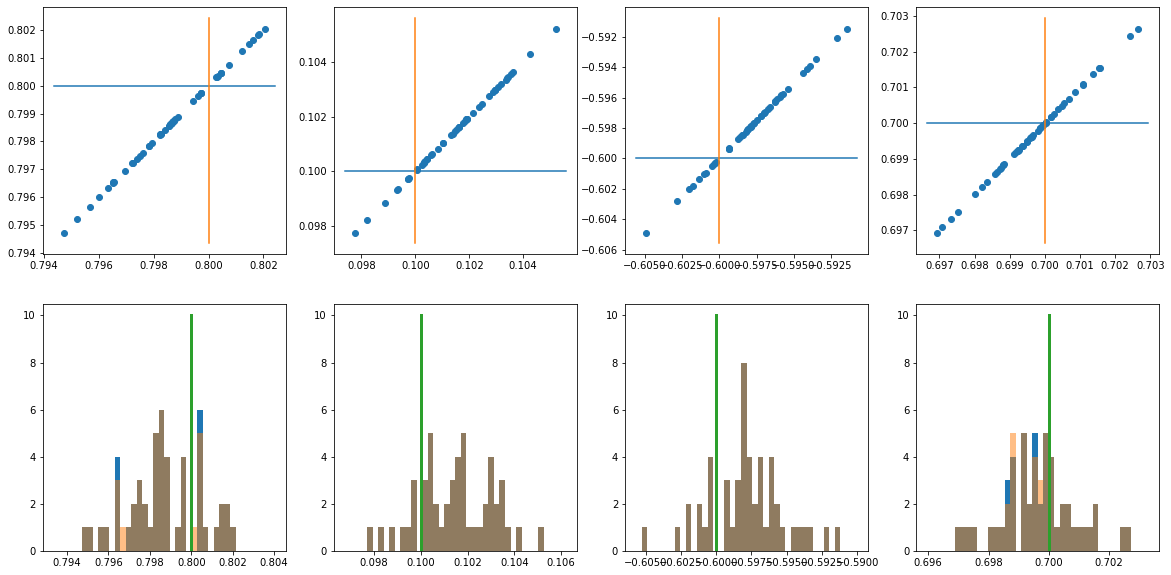

In [27]:
fig,ax = plt.subplots( 2, ndim, figsize=(5*ndim,5*2))

hbins=40
hmax = 10

for fi in range(ndim) :
    ax[0][fi].scatter( all_mean[fi,:], fit_results_mean_val[fi,:])
    xlow, xhigh = ax[0][fi].get_xlim()
    ylow, yhigh = ax[0][fi].get_ylim()
    print("  %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi, xlow, xhigh, ylow, yhigh))
    ax[0][fi].plot( (xlow, xhigh), (true_mu[fi], true_mu[fi]))
    ax[0][fi].plot( (true_mu[fi], true_mu[fi]), (ylow, yhigh))
    

    ax[1][fi].hist( fit_results_mean_val[fi,:], bins=hbins, 
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    ax[1][fi].hist( all_mean[fi,:], bins=hbins, alpha=0.5,
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    ax[1][fi].plot( (true_mu[fi],true_mu[fi]),(0,hmax), linewidth=3)
    

plt.show

   0,  0 : x axis limits:  0.638, 0.652    y axis limits  0.638, 0.652
   0,  1 : x axis limits:  -0.004, 0.001    y axis limits  -0.004, 0.001
   0,  2 : x axis limits:  -0.246, -0.233    y axis limits  -0.246, -0.233
   0,  3 : x axis limits:  0.188, 0.193    y axis limits  0.188, 0.193
   1,  1 : x axis limits:  0.360, 0.368    y axis limits  0.360, 0.368
   1,  2 : x axis limits:  0.117, 0.124    y axis limits  0.117, 0.124
   1,  3 : x axis limits:  -0.001, 0.003    y axis limits  -0.001, 0.003
   2,  2 : x axis limits:  0.992, 1.011    y axis limits  0.991, 1.011
   2,  3 : x axis limits:  0.296, 0.304    y axis limits  0.296, 0.304
   3,  3 : x axis limits:  0.357, 0.364    y axis limits  0.357, 0.364


<function matplotlib.pyplot.show(close=None, block=None)>

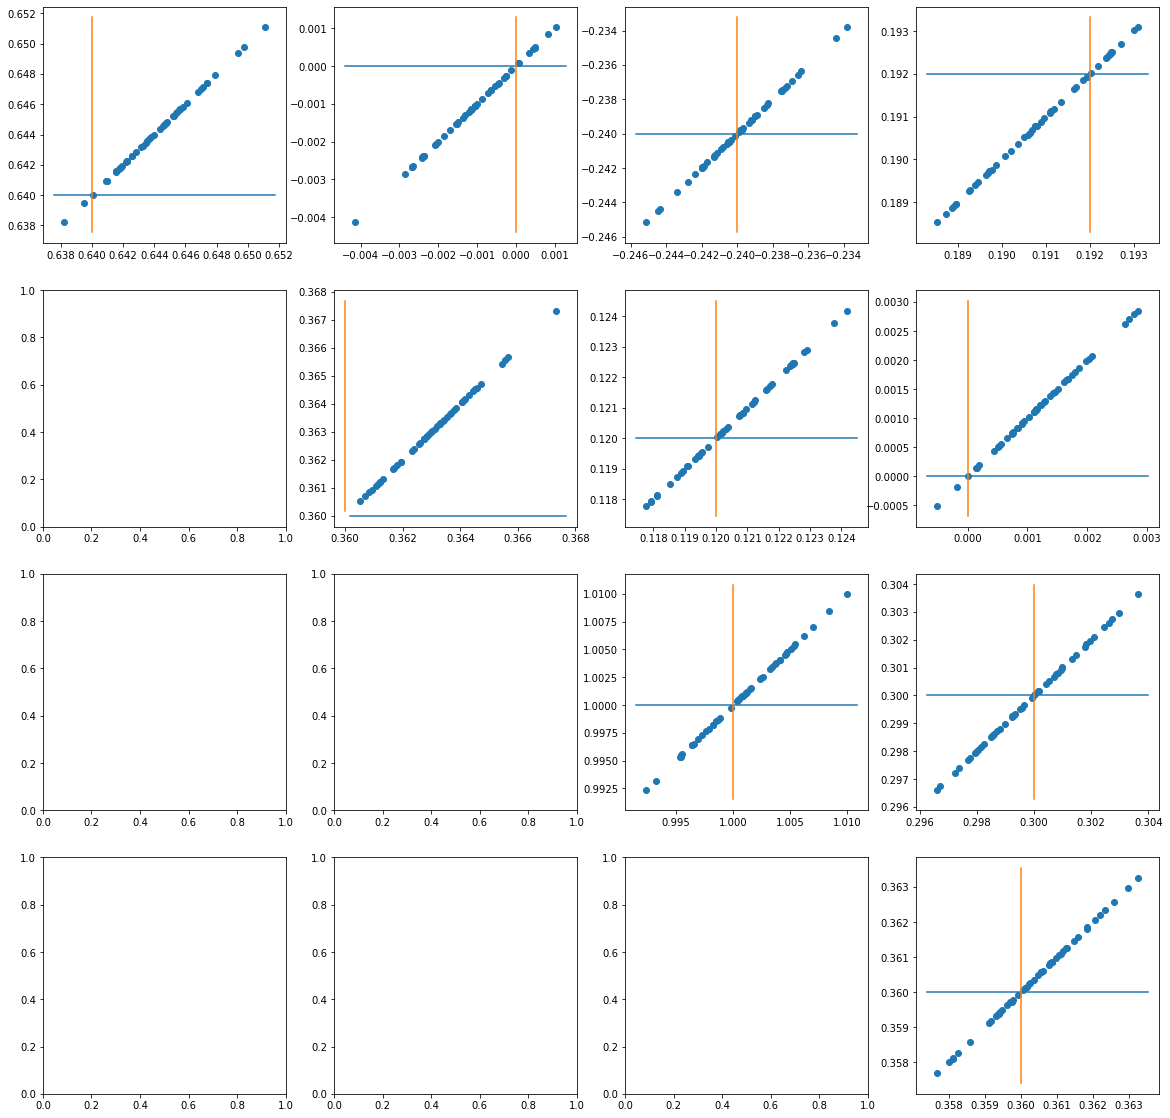

In [28]:
fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        ax[fi1][fi2].scatter( all_cov[fi1,fi2,:], fit_results_cov_val[fi1,fi2,:])
        xlow, xhigh = ax[fi1][fi2].get_xlim()
        ylow, yhigh = ax[fi1][fi2].get_ylim()
        print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi1, fi2, xlow, xhigh, ylow, yhigh))
        ax[fi1][fi2].plot((xlow,xhigh),(true_cov[fi1][fi2], true_cov[fi1][fi2]))
        ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(ylow,yhigh))

plt.show

   0,  0 : x axis limits:  0.635, 0.653    y axis limits  0.000, 5.250
   0,  1 : x axis limits:  -0.005, 0.002    y axis limits  0.000, 7.350
   0,  2 : x axis limits:  -0.248, -0.232    y axis limits  0.000, 7.350
   0,  3 : x axis limits:  0.187, 0.195    y axis limits  0.000, 6.300
   1,  1 : x axis limits:  0.358, 0.368    y axis limits  0.000, 4.200
   1,  2 : x axis limits:  0.115, 0.126    y axis limits  0.000, 7.350
   1,  3 : x axis limits:  -0.001, 0.004    y axis limits  0.000, 7.350
   2,  2 : x axis limits:  0.988, 1.014    y axis limits  0.000, 6.300
   2,  3 : x axis limits:  0.294, 0.305    y axis limits  0.000, 4.200
   3,  3 : x axis limits:  0.356, 0.365    y axis limits  0.000, 5.250


<function matplotlib.pyplot.show(close=None, block=None)>

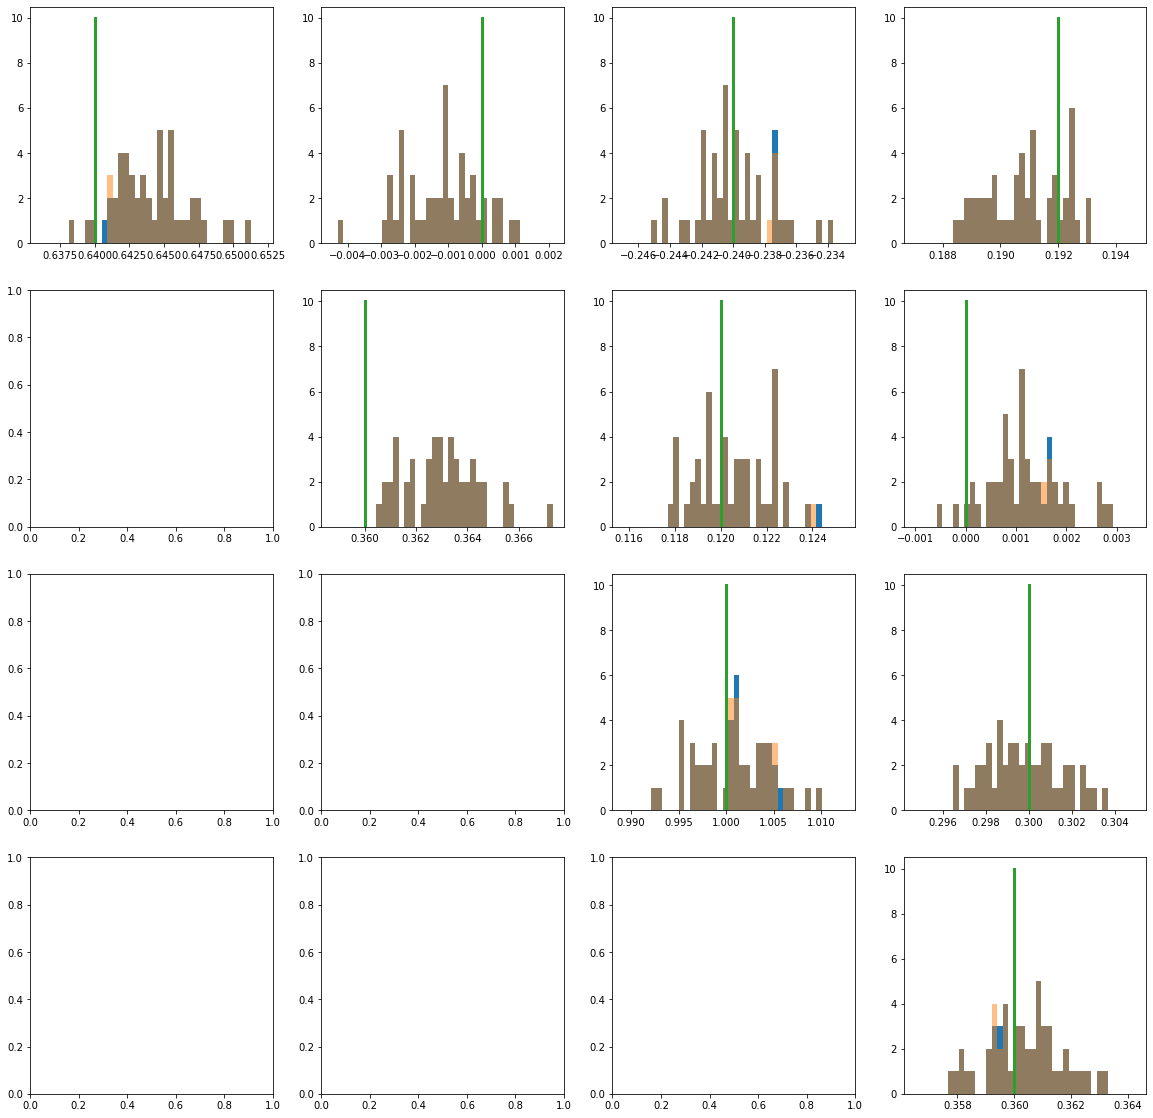

In [29]:
fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

hbins=40
hmax=10

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        ax[fi1][fi2].hist( fit_results_cov_val[fi1,fi2,:], bins=hbins, 
                         range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
        ax[fi1][fi2].hist( all_cov[fi1,fi2,:], bins=hbins, alpha=0.5,
                         range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
        xlow, xhigh = ax[fi1][fi2].get_xlim()
        ylow, yhigh = ax[fi1][fi2].get_ylim()
        print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi1, fi2, xlow, xhigh, ylow, yhigh))

        ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(0,hmax), linewidth=3)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

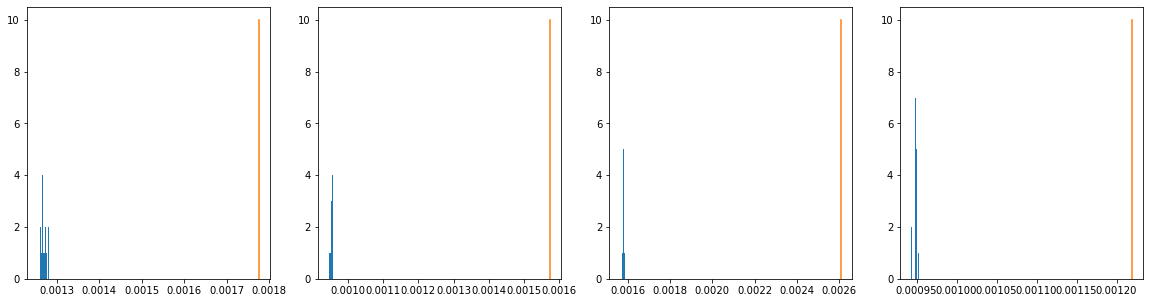

In [30]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins = 40
hmax = 10

for fi in range(ndim) :
    ax[fi].hist( fit_results_mean_err[fi,:], bins=hbins )
    ax[fi].plot( (rms_mean[fi], rms_mean[fi]), (0,hmax) )
    
    
plt.show

In [31]:
for fi in range(ndim) :
    
    print("  feature %d mean:   rms bootstraps %8.4f,  ave fit err %8.4f    ratio  %8.2f"
         % (fi, rms_mean[fi], ave_fit_err_mean[fi], rms_mean[fi] / ave_fit_err_mean[fi] ))

  feature 0 mean:   rms bootstraps   0.0018,  ave fit err   0.0013    ratio      1.40
  feature 1 mean:   rms bootstraps   0.0016,  ave fit err   0.0010    ratio      1.65
  feature 2 mean:   rms bootstraps   0.0026,  ave fit err   0.0016    ratio      1.65
  feature 3 mean:   rms bootstraps   0.0012,  ave fit err   0.0009    ratio      1.28
